In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import CIFAR10
import torchvision.transforms as T

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [73]:
batch_size = 16
transforms = T.Compose([T.ToTensor()])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

Files already downloaded and verified


<Figure size 640x480 with 0 Axes>

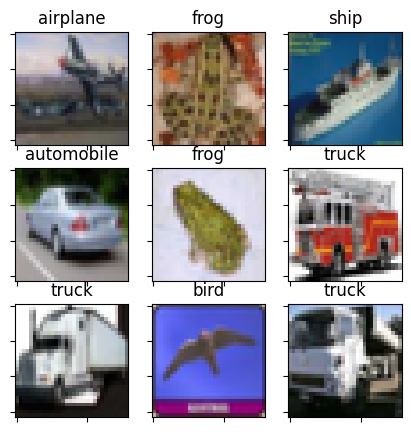

In [5]:
def plot_sample(dataset):
    idx = np.random.randint(0, dataset.data.shape[0], 9)
    plt.tight_layout()
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(5,5))
    for i in range(3):
        for j in range(3):
            axes[i][j].imshow(dataset.data[idx[3*i+j]])
            axes[i][j].set_xticklabels([])
            axes[i][j].set_yticklabels([])
            axes[i][j].set_title(dataset.classes[dataset.targets[idx[3*i+j]]])

plot_sample(train_dataset)

In [60]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(32*6*6, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, X):
        x = self.conv1(X)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [81]:
class Generator(nn.Module):
    def __init__(self, in_channel, in_dim, out_channel, out_dim):
        super().__init__()
        self.out_dim = out_dim
        self.n_conv = 3
        self.fc = nn.Sequential(
            nn.Linear(in_channel*in_dim*in_dim, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 64*(out_dim-(self.n_conv*2))*(out_dim-self.n_conv*2)),
            nn.Tanh(),
        )
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=out_channel, kernel_size=3),
            nn.Tanh()
        )

    def forward(self, X):
        x = torch.flatten(X, 1)
        x = self.fc(x)
        x = x.view(-1, 64, self.out_dim-(self.n_conv*2), self.out_dim-(self.n_conv*2))
        x = self.conv(x)
        return x

In [82]:
from torchsummary import summary
summary(Discriminator(3).to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             448
         LeakyReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
         MaxPool2d-4           [-1, 16, 15, 15]               0
            Conv2d-5           [-1, 32, 13, 13]           4,640
         LeakyReLU-6           [-1, 32, 13, 13]               0
       BatchNorm2d-7           [-1, 32, 13, 13]              64
         MaxPool2d-8             [-1, 32, 6, 6]               0
            Linear-9                  [-1, 128]         147,584
             Tanh-10                  [-1, 128]               0
           Linear-11                    [-1, 1]             129
          Sigmoid-12                    [-1, 1]               0
Total params: 152,897
Trainable params: 152,897
Non-trainable params: 0
-------------------------------

In [83]:
summary(Generator(in_channel=3, in_dim=32, out_channel=3, out_dim=32).to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1024]       3,146,752
         LeakyReLU-2                 [-1, 1024]               0
            Linear-3                 [-1, 1024]       1,049,600
         LeakyReLU-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
         LeakyReLU-6                  [-1, 512]               0
            Linear-7                [-1, 43264]      22,194,432
              Tanh-8                [-1, 43264]               0
   ConvTranspose2d-9           [-1, 32, 28, 28]          18,464
        LeakyReLU-10           [-1, 32, 28, 28]               0
  ConvTranspose2d-11           [-1, 16, 30, 30]           4,624
        LeakyReLU-12           [-1, 16, 30, 30]               0
  ConvTranspose2d-13            [-1, 3, 32, 32]             435
             Tanh-14            [-1, 3,

In [84]:
temp = Generator(in_channel=3, in_dim=32, out_channel=3, out_dim=32)

In [85]:
temp_img = torch.randn(1, 3, 32, 32)
out = temp(temp_img)

torch.Size([1, 3, 32, 32])


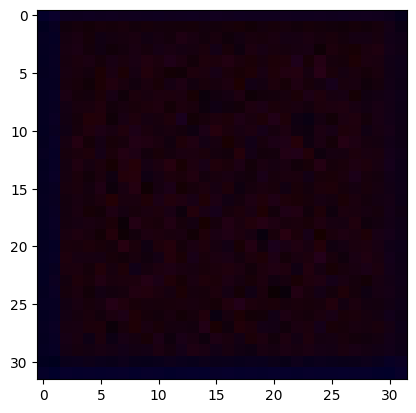

In [86]:
print(out.shape)
plt.imshow(out[0].detach().numpy().T)

In [87]:
def train(generator, discriminator, real_data, epochs, batch_size):
    loss_fn = nn.BCELoss()

    d_optimizer = optim.SGD(discriminator.parameters(), lr=0.001, momentum=0.9)
    g_optimizer = optim.SGD(generator.parameters(), lr=0.001, momentum=0.9)
    d_history = {'loss':[]}
    g_history = {'loss':[]}
    for ep in range(epochs):
        for i, data in enumerate(real_data):
            # Noise Generation
            noise = torch.randn(batch_size, 3, 32, 32)
            noise = noise.to(device)

            # Fake Data
            fake_data = generator(noise)

            # Discriminator Training
            inputs = data[0].to(device)
            real_out = discriminator(inputs)
            fake_out = discriminator(fake_data)

            real_loss = loss_fn(real_out, torch.ones(batch_size, 1, device=device))
            fake_loss = loss_fn(fake_out, torch.zeros(batch_size, 1, device=device))

            d_optimizer.zero_grad()
            real_loss.backward(retain_graph=True)
            fake_loss.backward(retain_graph=True)
            d_optimizer.step()

            # Generator Training
            fake_out = discriminator(fake_data)
            g_loss = loss_fn(fake_out, torch.ones(batch_size, 1, device=device))
            g_optimizer.zero_grad()
            g_loss.backward(retain_graph=True)
            g_optimizer.step()

            if i%1000 == 0:
                with torch.inference_mode():
                    d_loss = real_loss.item() + fake_loss.item()
                    d_history['loss'].append(d_loss)
                    g_history['loss'].append(g_loss.item())
                    print(f'Epoch: {ep+1} Step {i} Discriminator_loss: {d_loss:.5f} Generator_loss: {g_loss.item():.5f}')
    return d_history, g_history


In [88]:
generator = Generator(in_channel=3, in_dim=32, out_channel=3, out_dim=32)
discriminator = Discriminator(in_channels=3)
generator.to(device)
discriminator.to(device)
epochs = 10
d_history, g_history = train(generator, discriminator, train_dataloader, epochs, batch_size)

Epoch: 1 Step 0 Discriminator_loss: 1.52294 Generator_loss: 0.66844
Epoch: 1 Step 1000 Discriminator_loss: 0.00371 Generator_loss: 6.00937
Epoch: 1 Step 2000 Discriminator_loss: 0.00118 Generator_loss: 7.28612
Epoch: 1 Step 3000 Discriminator_loss: 0.00061 Generator_loss: 7.61433
Epoch: 2 Step 0 Discriminator_loss: 0.00131 Generator_loss: 7.68401
Epoch: 2 Step 1000 Discriminator_loss: 0.00046 Generator_loss: 8.08803
Epoch: 2 Step 2000 Discriminator_loss: 0.00035 Generator_loss: 8.40211
Epoch: 2 Step 3000 Discriminator_loss: 0.00025 Generator_loss: 8.62730
Epoch: 3 Step 0 Discriminator_loss: 0.00331 Generator_loss: 8.66759
Epoch: 3 Step 1000 Discriminator_loss: 0.00107 Generator_loss: 8.80186
Epoch: 3 Step 2000 Discriminator_loss: 0.00025 Generator_loss: 8.81805
Epoch: 3 Step 3000 Discriminator_loss: 0.00019 Generator_loss: 10.08232
Epoch: 4 Step 0 Discriminator_loss: 0.00011 Generator_loss: 10.19404
Epoch: 4 Step 1000 Discriminator_loss: 0.00005 Generator_loss: 10.76403
Epoch: 4 Step 2

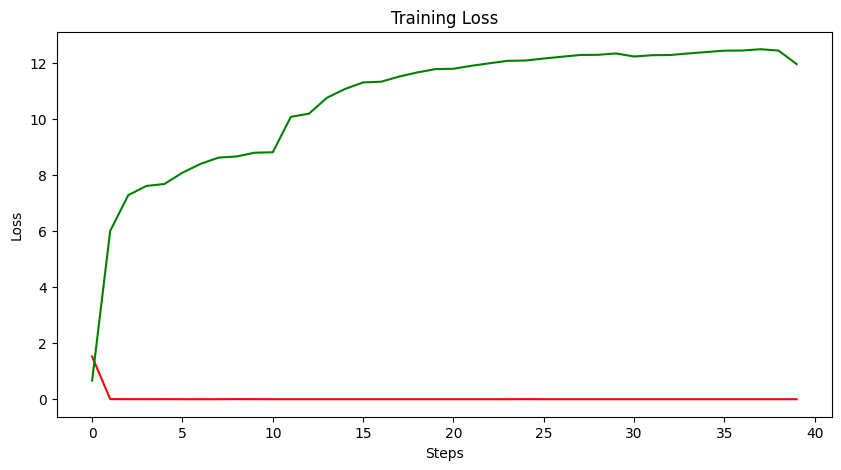

In [89]:
def plot_results(d_history, g_history):
    plt.figure(figsize=(10, 5))
    plt.plot(d_history['loss'], color='r', label='Discriminator')
    plt.plot(g_history['loss'], color='g', label='Generator')
    plt.title("Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend

plot_results(d_history, g_history)

/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


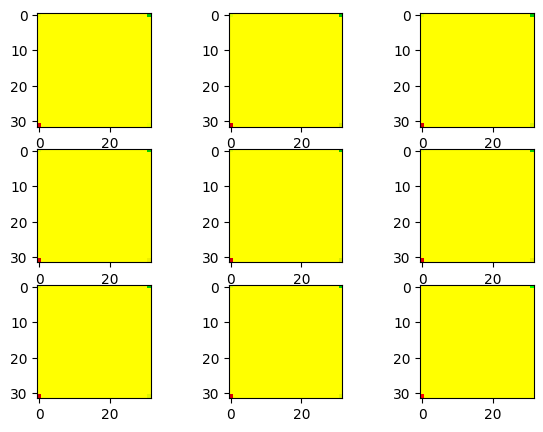

In [47]:
temp_img = torch.randn(9, 3, 32, 32, device=device)
out = generator(temp_img)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7,5))
for i in range(3):
    for j in range(3):
        out[3*i+j][0] = (out[3*i+j][0] - out[3*i+j][0].min())/(out[3*i+j][0].max() - out[3*i+j][0].min())
        out[3*i+j][1] = (out[3*i+j][1] - out[3*i+j][1].min())/(out[3*i+j][1].max() - out[3*i+j][1].min())
        out[3*i+j][2] = (out[3*i+j][2] - out[3*i+j][2].min())/(out[3*i+j][2].max() - out[3*i+j][2].min())
        axes[i][j].imshow(out[3*i+j].detach().cpu().numpy().T)

(-0.5, 147.5, 147.5, -0.5)

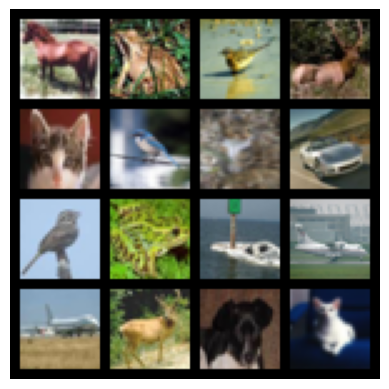

In [76]:
from torchvision.utils import make_grid

grid = make_grid(next(iter(train_dataloader))[0], 4, 4)
plt.imshow(grid.permute(1, 2, 0).numpy())
plt.axis('off')